In [38]:

import pandas as pd
import numpy as np
from numpy import mean,std
import shap
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold,RandomizedSearchCV
from sklearn.metrics import precision_score,accuracy_score,recall_score, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import  roc_curve, RocCurveDisplay

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import warnings
import sys
from sklearn.metrics import silhouette_score

In [2]:
pd_abundance = pd.read_excel('GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.xls')
pd_abundance

,OTU,taxonomy,A1,A10,A100,A101,A102,A104,A105,A106,...,B52,B54,B55,B56,B57,B58,B59,B6,B60,B61
0,OTU1,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clos...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,OTU2,d__Bacteria;_k__norank;_p__Proteobacteria;_c__...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,OTU3,d__Bacteria;_k__norank;_p__Firmicutes;_c__Erys...,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,OTU4,d__Bacteria;_k__norank;_p__Firmicutes;_c__Baci...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,OTU5,d__Bacteria;_k__norank;_p__Tenericutes;_c__Mol...,0,0,1,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,OTU1334,d__Bacteria;_k__norank;_p__Bacteroidetes;_c__B...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1318,OTU1335,d__Bacteria;_k__norank;_p__Actinobacteria;_c__...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1319,OTU1336,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clos...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1320,OTU1337,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clos...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
taxa = pd_abundance[['OTU', 'taxonomy']].set_index('OTU')
pd_abundance_T = pd_abundance.drop('taxonomy', axis=1).set_index('OTU').transpose()

target = pd_abundance_T.index.to_list()
binary_target = np.array([1 if t.startswith('A') else 0 for t in target ])

total_species = pd_abundance_T.sum(axis = 1)
abs_abundance = 31757
pd_rel_abundance = pd_abundance_T / abs_abundance 

In [4]:
X=pd_rel_abundance
y=binary_target

In [6]:
metadata=pd.read_excel('Table S1 Sample information.xlsx',index_col=0)
metadata=metadata.loc[X.index]
metadata.to_csv('metadata.csv')

In [7]:
np.random.seed(1) # Reproducibility 
CV_repeats = 50
# Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
random_states = np.random.randint(10000, size=CV_repeats) 

######## Use a dict to track the SHAP values of each observation per CV repitition 

shap_values_per_cv = dict()
for sample in X.index:
    ## Create keys for each sample
    shap_values_per_cv[sample] = {} 
    ## Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}
        
######## Use a dict to track the output probability of each observation per CV repitition   

prob_per_cv = dict()
for sample in X.index:
    ## Create keys for each sample
    prob_per_cv[sample] = {} 
    ## Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_repeats):
        prob_per_cv[sample][CV_repeat] = {}


------------ CV Repeat number: 0

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------ Fold Number: 5

------ Fold Number: 6

------ Fold Number: 7

------ Fold Number: 8

------ Fold Number: 9

------------ CV Repeat number: 1

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------ Fold Number: 5

------ Fold Number: 6

------ Fold Number: 7

------ Fold Number: 8

------ Fold Number: 9

------------ CV Repeat number: 2

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------ Fold Number: 5

------ Fold Number: 6

------ Fold Number: 7

------ Fold Number: 8

------ Fold Number: 9

------------ CV Repeat number: 3

------ Fold Number: 0

------ Fold Number: 1

------ Fold Number: 2

------ Fold Number: 3

------ Fold Number: 4

------ Fold Number: 5

------ Fold Number: 6

------ Fold 

<Figure size 9000x6000 with 0 Axes>

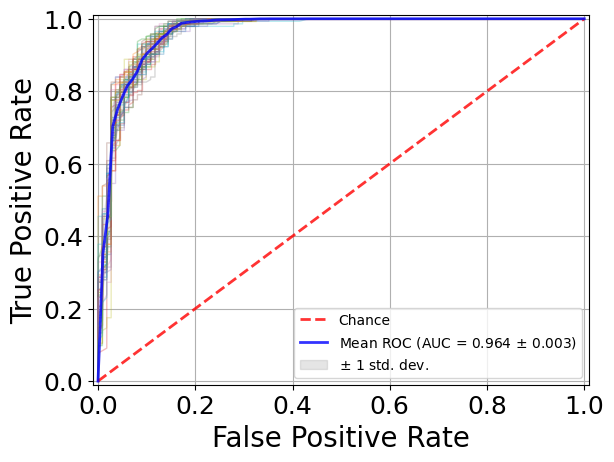

In [8]:
plt.figure(figsize=(15, 10), dpi=600)
fig, ax = plt.subplots()
param_grid = [{'max_depth': [None,3,5],

               'n_estimators': np.arange(50,300,50)
              }]

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
importance_rf=pd.DataFrame(columns=X.columns)
sens_rf=list()
spec_rf=list()
auc_rf=list()
acc_rf=list()
prec_rf=list()

for i, CV_repeat in enumerate(range(CV_repeats)): #-#-#
    #Verbose 
    print('\n------------ CV Repeat number:', CV_repeat)
    #Establish CV scheme
    CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_states[i]) # Set random state 

    ix_training, ix_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X,y):
        ix_training.append(fold[0]), ix_test.append(fold[1])
    
    predicted=[]
    label=[]
    score=[]
    
    ## Loop through each outer fold and extract SHAP values 
    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
        #Verbose
        print('\n------ Fold Number:',i)
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        y_train, y_test = y[train_outer_ix], y[test_outer_ix]

        #standard scaler
        sc = StandardScaler()
        sc.fit(X_train, y_train)
        X_train=sc.transform(X_train)
        X_test=sc.transform(X_test)
        
        ## Establish inner CV for parameter optimization #-#-#
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) #-#-#
        
        # Search to optimize hyperparameters
        model = RandomForestClassifier(random_state=0)
        search = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv=cv_inner, refit=True,random_state=0) #-#-#
        result = search.fit(X_train, y_train) #-#=#
        
        best_model=result.best_estimator_
        # Fit model on training data 
        best_model.fit(X_train, y_train) #-#-#
        
        
        yhat = best_model.predict(X_test)
        
        y_score = best_model.predict_proba(X_test)[:, 1]
        
        label.append(y_test)
        
        predicted.append(yhat)
        score.append(y_score)
        
        # Extract output prob information per fold per sample 
        for i, test_index in enumerate(X.index[test_outer_ix]):
            prob_per_cv[test_index][CV_repeat] = y_score[i] #-#-#
        

        coef=pd.DataFrame(best_model.feature_importances_.reshape(1,-1),columns=X.columns)
       
        importance_rf=pd.concat([importance_rf,coef],ignore_index=True)
        
        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)[1]

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(X.index[test_outer_ix]):
            shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
            
    acc_sc=accuracy_score(np.hstack(label), np.hstack(predicted))
    acc_rf.append(acc_sc)
    #print('Accuracy:',round(acc,4))
    
    sens_sc=recall_score(np.hstack(label), np.hstack(predicted),pos_label=1)
    sens_rf.append(sens_sc)
    #print('Sensitivity:',round(sens,4))

    spec_sc=recall_score(np.hstack(label), np.hstack(predicted),pos_label=0)
    spec_rf.append(spec_sc)
    #print('Specificity:',round(spec,4))

    prec_sc=precision_score(np.hstack(label), np.hstack(predicted),pos_label=1)
    prec_rf.append(prec_sc)
    #print('Precision:',round(prec,4))

    auc_sc=roc_auc_score(np.hstack(label), np.hstack(score))
    auc_rf.append(auc_sc)
    #print('Roc AUC:',round(auc,4))
    
    #ROC
    fpr, tpr, threshold= roc_curve(np.hstack(label), np.hstack(score))
    tprs.append(np.interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
    roc_auc=metrics.auc(fpr,tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)
            

plt.plot([0,1], [0,1], linestyle='--', lw=2,color='r', label='Chance',alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Repeated Cross-Validation ROC',fontsize=18)
plt.legend(loc="lower right"
           #,bbox_to_anchor=(1.65, 0.01)
           #, prop={'size': 22}
          )

plt.grid()
plt.show()    
#fig.savefig('roc.eps', format='eps',dpi=300)

<Figure size 1920x1440 with 0 Axes>

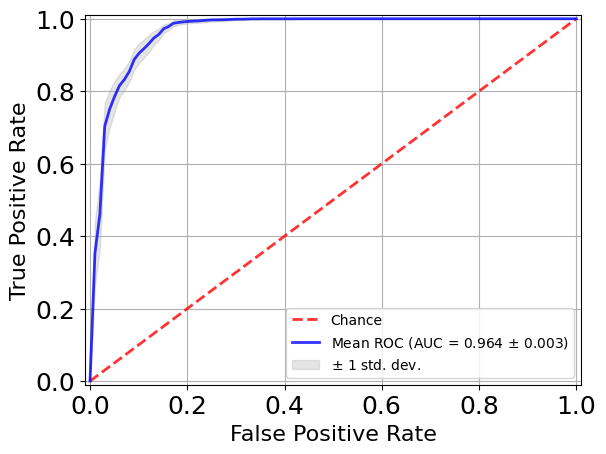

In [10]:
plt.figure(dpi=300)
fig, ax = plt.subplots()
plt.plot([0,1], [0,1], linestyle='--', lw=2,color='r', label='Chance',alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Repeated Cross-Validation ROC',fontsize=18)
plt.legend(loc="lower right"
           #,bbox_to_anchor=(1.65, 0.01)
           #, prop={'size': 22}
          )

plt.grid()
plt.show()

In [9]:
print('ACC: %.3f (%.3f)' % (mean(acc_rf), std(acc_rf)))
print('Sensitivity: %.3f (%.3f)' % (mean(sens_rf), std(sens_rf)))
print('Specificity: %.3f (%.3f)' % (mean(spec_rf), std(spec_rf)))
print('Precision: %.3f (%.3f)' % (mean(prec_rf), std(prec_rf)))
print('Auc: %.3f (%.3f)' % (mean(auc_rf), std(auc_rf)))

ACC: 0.921 (0.006)
Sensitivity: 0.978 (0.010)
Specificity: 0.847 (0.011)
Precision: 0.892 (0.007)
Auc: 0.965 (0.003)


In [11]:
results=pd.DataFrame(np.concatenate((acc_rf,sens_rf,spec_rf,prec_rf,auc_rf)),columns=['Score'])
results['Metric']=np.concatenate((np.repeat('Accuracy',len(acc_rf)),
                                  np.repeat('Sensitivity',len(sens_rf)),np.repeat('Specificity',len(spec_rf)),
                                 np.repeat('Precision',len(prec_rf)),np.repeat('AUC',len(auc_rf))))


In [12]:
results.to_csv('results_rf.csv')

In [13]:
# Melted data i.e., long format
df_importance_rf = pd.melt(importance_rf,var_name='feature name', value_name='coef. of importance')
grouped_rf = df_importance_rf.loc[:,['feature name', 'coef. of importance']] \
    .groupby(['feature name']) \
    .median() \
    .sort_values(by='coef. of importance',ascending=False)

Text(0, 0.5, 'Feature')

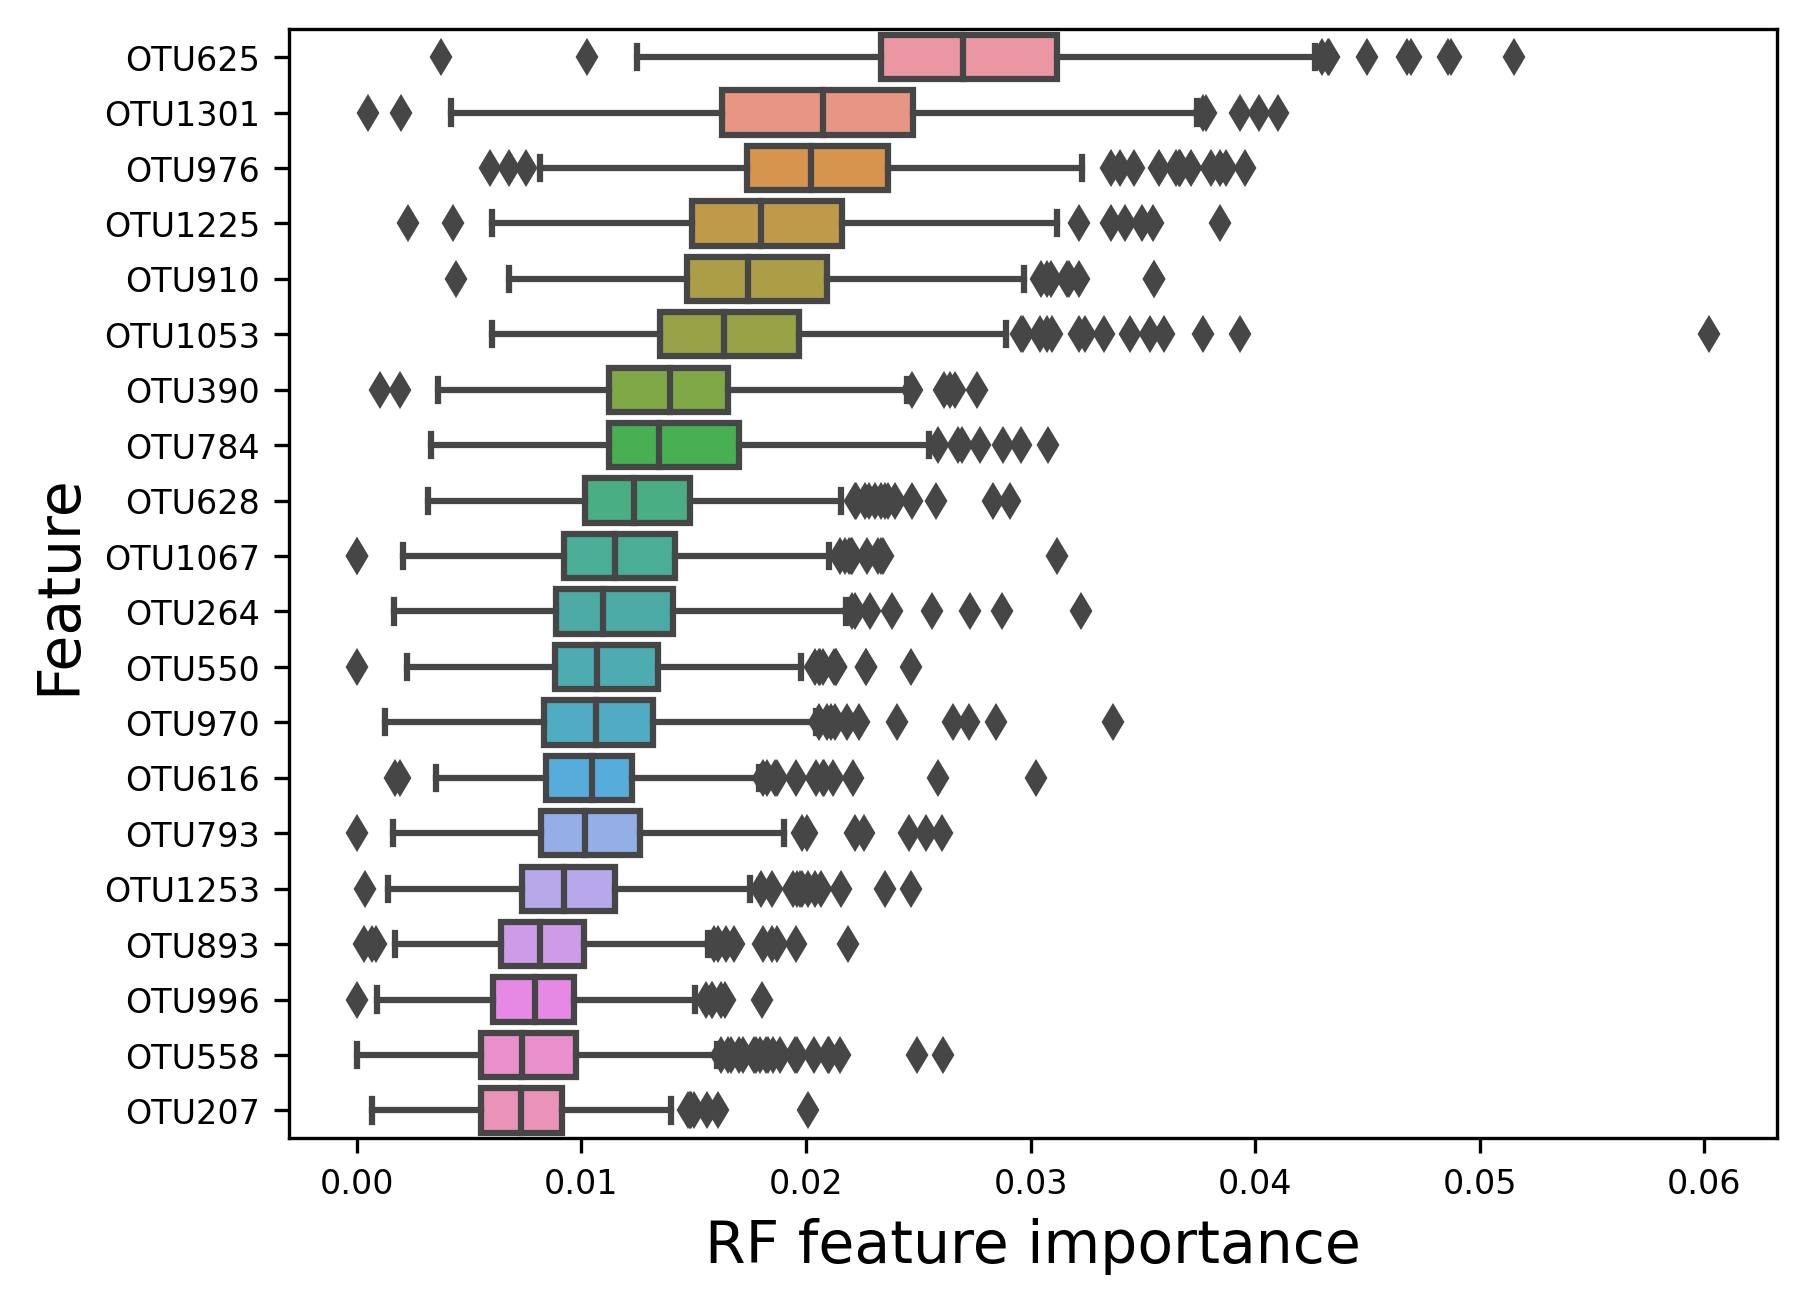

In [14]:
plt.figure(dpi=300)
sns.boxplot(y="feature name", x="coef. of importance", data=df_importance_rf,order=grouped_rf.index[:20])


plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('RF feature importance',fontsize=14)
plt.ylabel('Feature',fontsize=14)
#plt.title('XGBoost feature importance')
#plt.savefig('feature_imp.eps', format='eps',dpi=300)

In [15]:
# Establish lists to keep average prob values, their Stds, and their min and max
average_prob, prob_stds, prob_ranges = [],[],[]

for i in X.index:
    df_per_obs = pd.DataFrame([prob_per_cv[i]]) # Get all prob  values for sample number i
    # Get relevant statistics for every sample 
    average_prob.append(df_per_obs.mean(axis=1).values) 
    prob_stds.append(df_per_obs.std(axis=1).values)
    prob_ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)
average_prob=np.hstack(average_prob)

In [16]:
# Establish lists to keep average Shap values, their Stds, and their min and max
average_shap_values, stds, ranges = [],[],[]

for i in X.index:
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

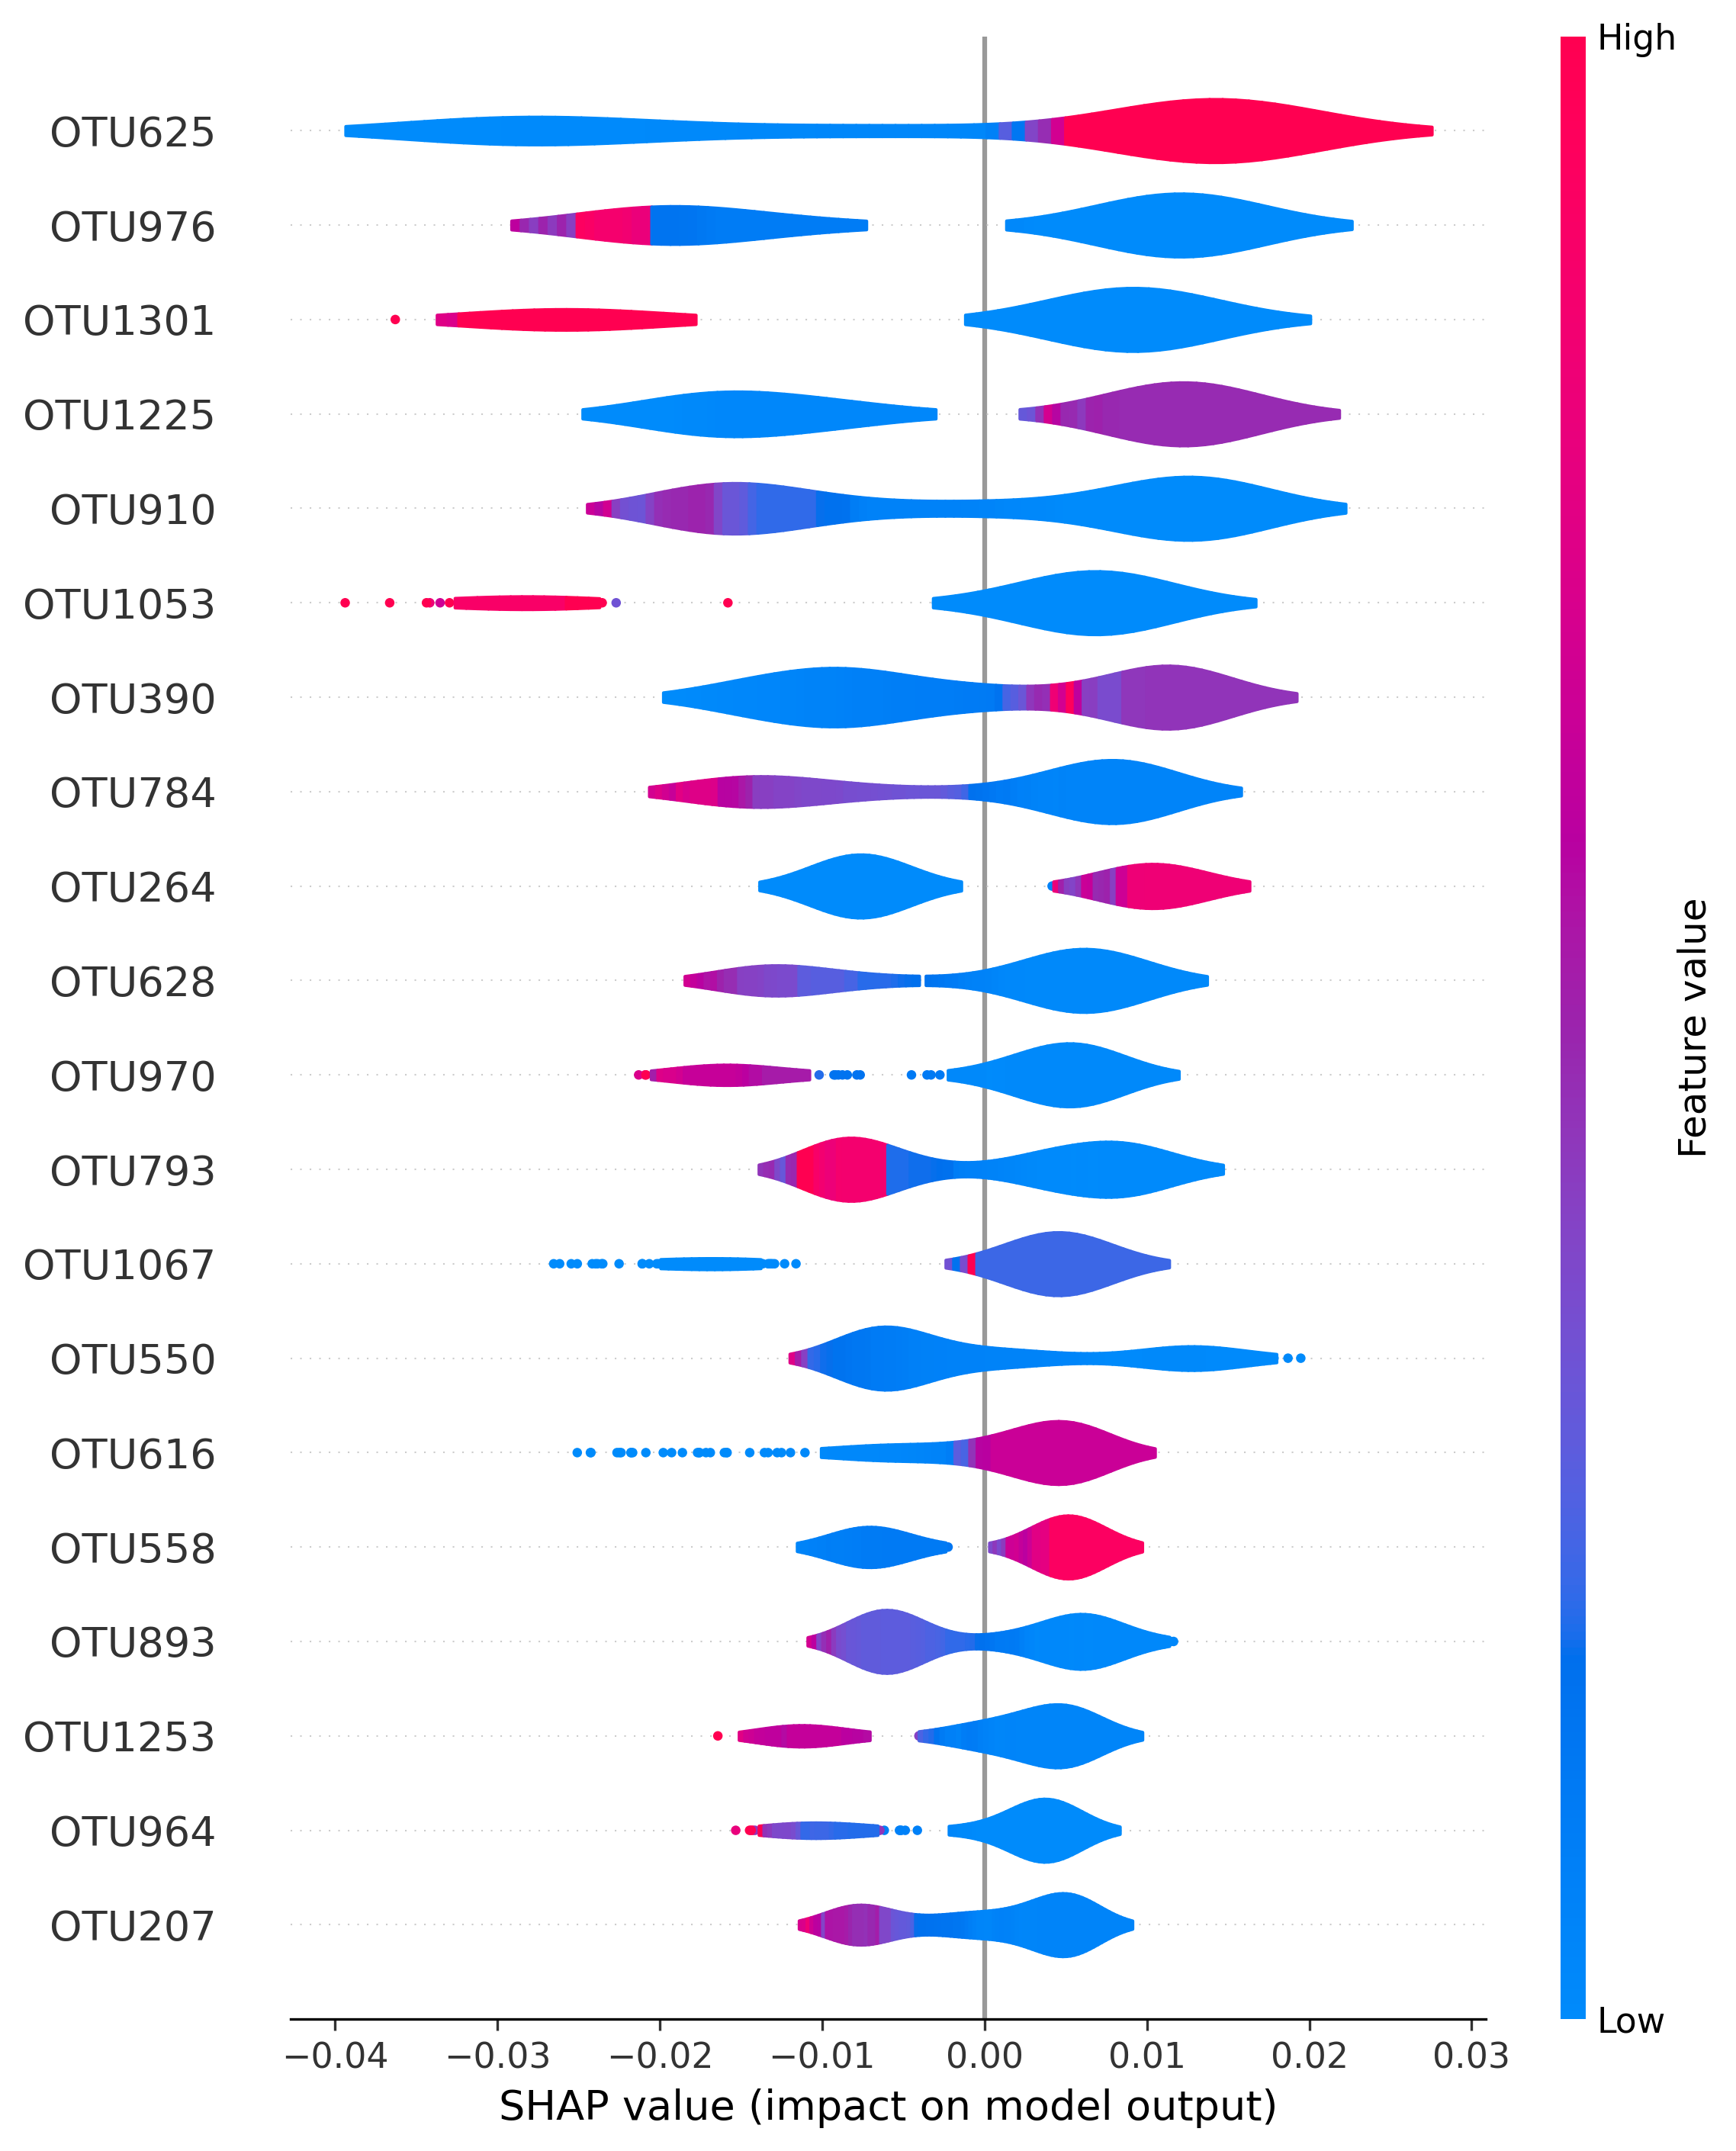

In [17]:
plt.figure(dpi=300)
shap.summary_plot(np.array(average_shap_values), X,plot_type='violin',max_display=20)

# Jaccard index between xgb and shap feature importance

In [18]:
rf_feature=np.array(grouped_rf.index[:20])

vals= np.abs(np.array(average_shap_values)).mean(0)

shap_feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name','feature_importance_vals'])
shap_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
shap_feature_importance=shap_feature_importance.head(20)
shap_feature=shap_feature_importance['col_name'].values

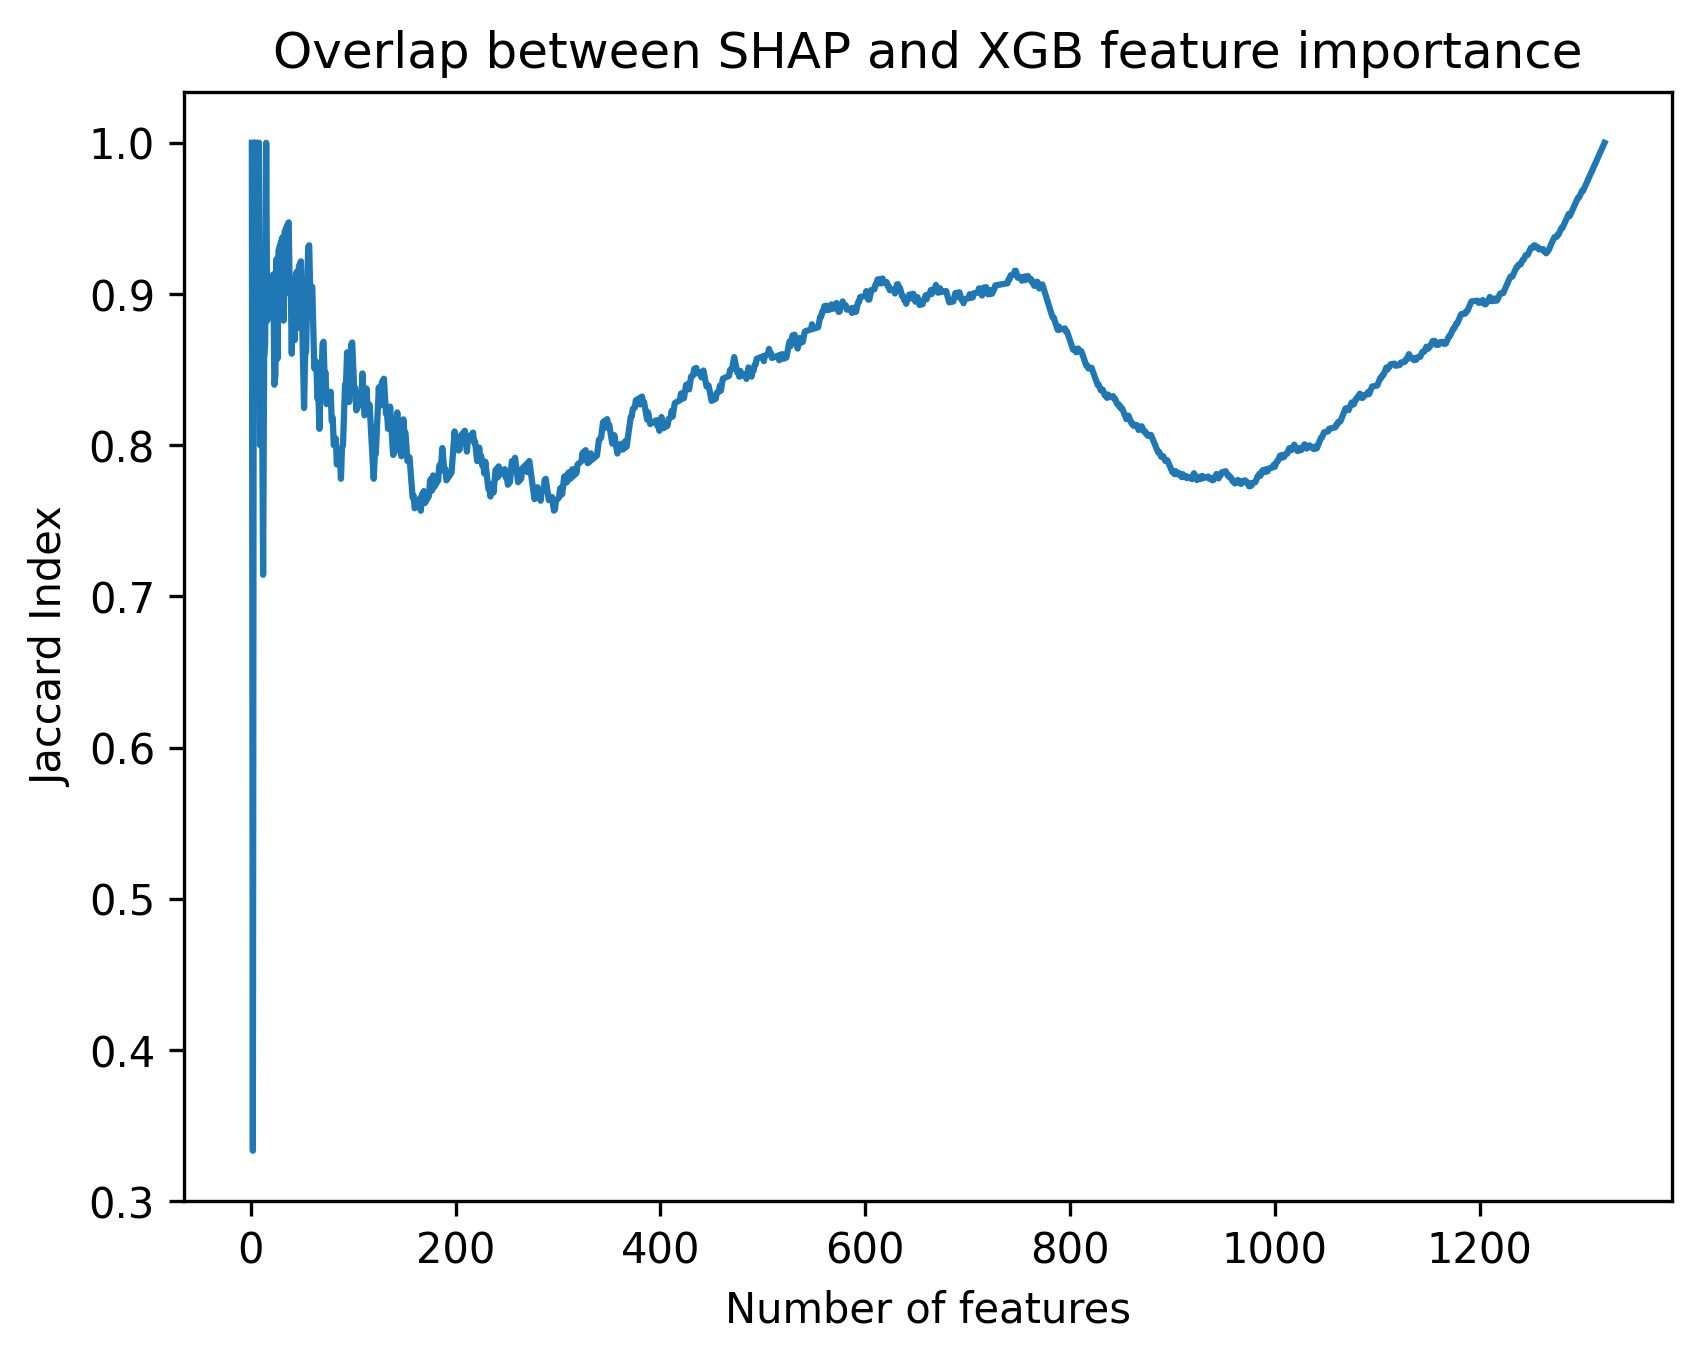

In [20]:
vals= np.abs(np.array(average_shap_values)).mean(0)

   

shap_feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name','feature_importance_vals'])
shap_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

I_j=[]

for n in range(1,1+len(X.columns)):
    
    S=shap_feature_importance.head(n)
    S=S['col_name'].values
    RF=np.array(grouped_rf.index[:n])
    
    intersect_len=len(set(S).intersection(set(RF)))
    union_len=len(set(S).union(set(RF)))
    
    I_j.append(intersect_len/union_len)

plt.figure(dpi=300)
plt.xlabel('Number of features')
plt.ylabel('Jaccard Index')
plt.title('Overlap between SHAP and XGB feature importance')
#plt.xlim((5,200))
plt.plot(list(range(1,1+len(X.columns))),I_j)

In [21]:
intersect_len=len(set(shap_feature).intersection(set(rf_feature)))
union_len=len(set(shap_feature).union(set(rf_feature)))
print('intersection len: ',intersect_len,', union len: ', union_len)
print('Jaccard Index: ', np.round(intersect_len/union_len,2))

intersection len:  19 , union len:  21
Jaccard Index:  0.9


# PCA of X columns + loadings

In [23]:

targets = y
targets=np.where(targets ==1, 'ASD', 'TD')

features = X.columns

# analysis

pca = PCA(n_components=2).fit(X)
X_reduced = pca.transform(X)

# results
scores = X_reduced[:, :2]
loadings = pca.components_[:2].T
pvars = pca.explained_variance_ratio_[:2] * 100


In [24]:
k=5
tops = (loadings ** 2).sum(axis=1).argsort()[-k:]
arrows = loadings[tops]
arrows /= np.sqrt((arrows ** 2).sum(axis=0))
arrows *= np.abs(scores).max(axis=0)

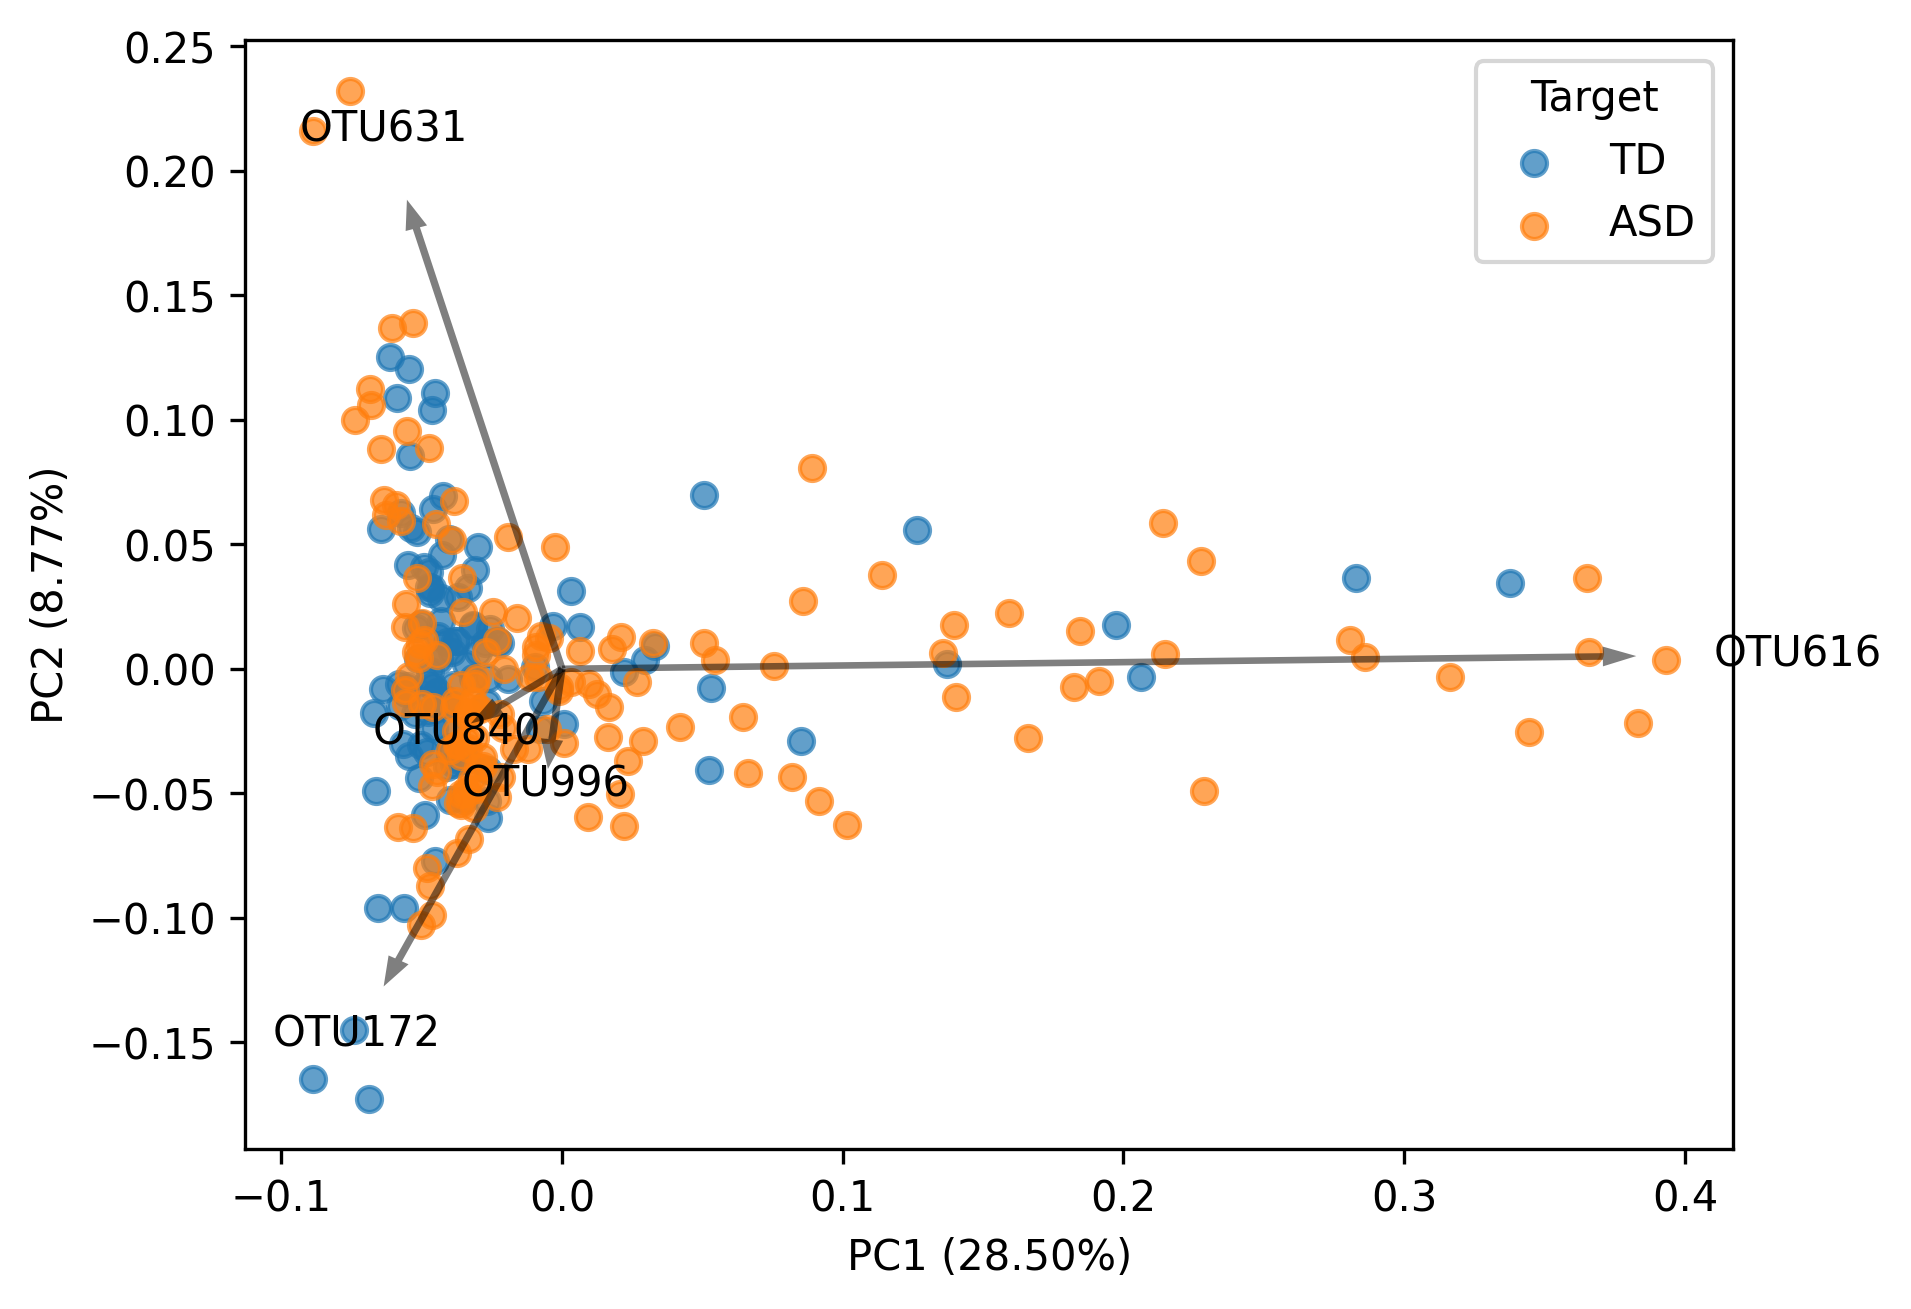

In [25]:

plt.figure(dpi=300)
for i,name in enumerate(['TD','ASD']):
    plt.scatter(*zip(*scores[y == i]), label=name , alpha=0.7)
plt.legend(title='Target')

width = -0.005 * np.min([np.subtract(*plt.xlim()), np.subtract(*plt.ylim())])
for i, arrow in zip(tops, arrows):
    plt.arrow(0, 0, *arrow, color='k', alpha=0.5, width=width, ec='none',
              length_includes_head=True)
    plt.text(*(arrow * 1.15), features[i], ha='center', va='center')

for i, axis in enumerate('xy'):
    getattr(plt, f'{axis}ticks')#([])
    getattr(plt, f'{axis}label')(f'PC{i + 1} ({pvars[i]:.2f}%)')
    
plt.show()

# PCA of shap

In [26]:
targets = y
targets=np.where(targets ==1, 'ASD', 'TD')

features = X.columns

# analysis

pca_shap = PCA(n_components=2).fit(np.array(average_shap_values))
X_reduced_pca = pca_shap.transform(np.array(average_shap_values))

# results
scores_shap = X_reduced_pca[:, :2]
loadings_shap = pca_shap.components_[:2].T
pvars_shap = pca_shap.explained_variance_ratio_[:2] * 100

In [27]:
k=5
#tops = (loadings_shap * pvars_shap).sum(axis=1).argsort()[-k:]
#arrows = loadings_shap[tops]

tops = (loadings_shap ** 2).sum(axis=1).argsort()[-k:]
arrows = loadings_shap[tops]

arrows /= np.sqrt((arrows ** 2).sum(axis=0))
arrows *= np.abs(scores_shap).max(axis=0)

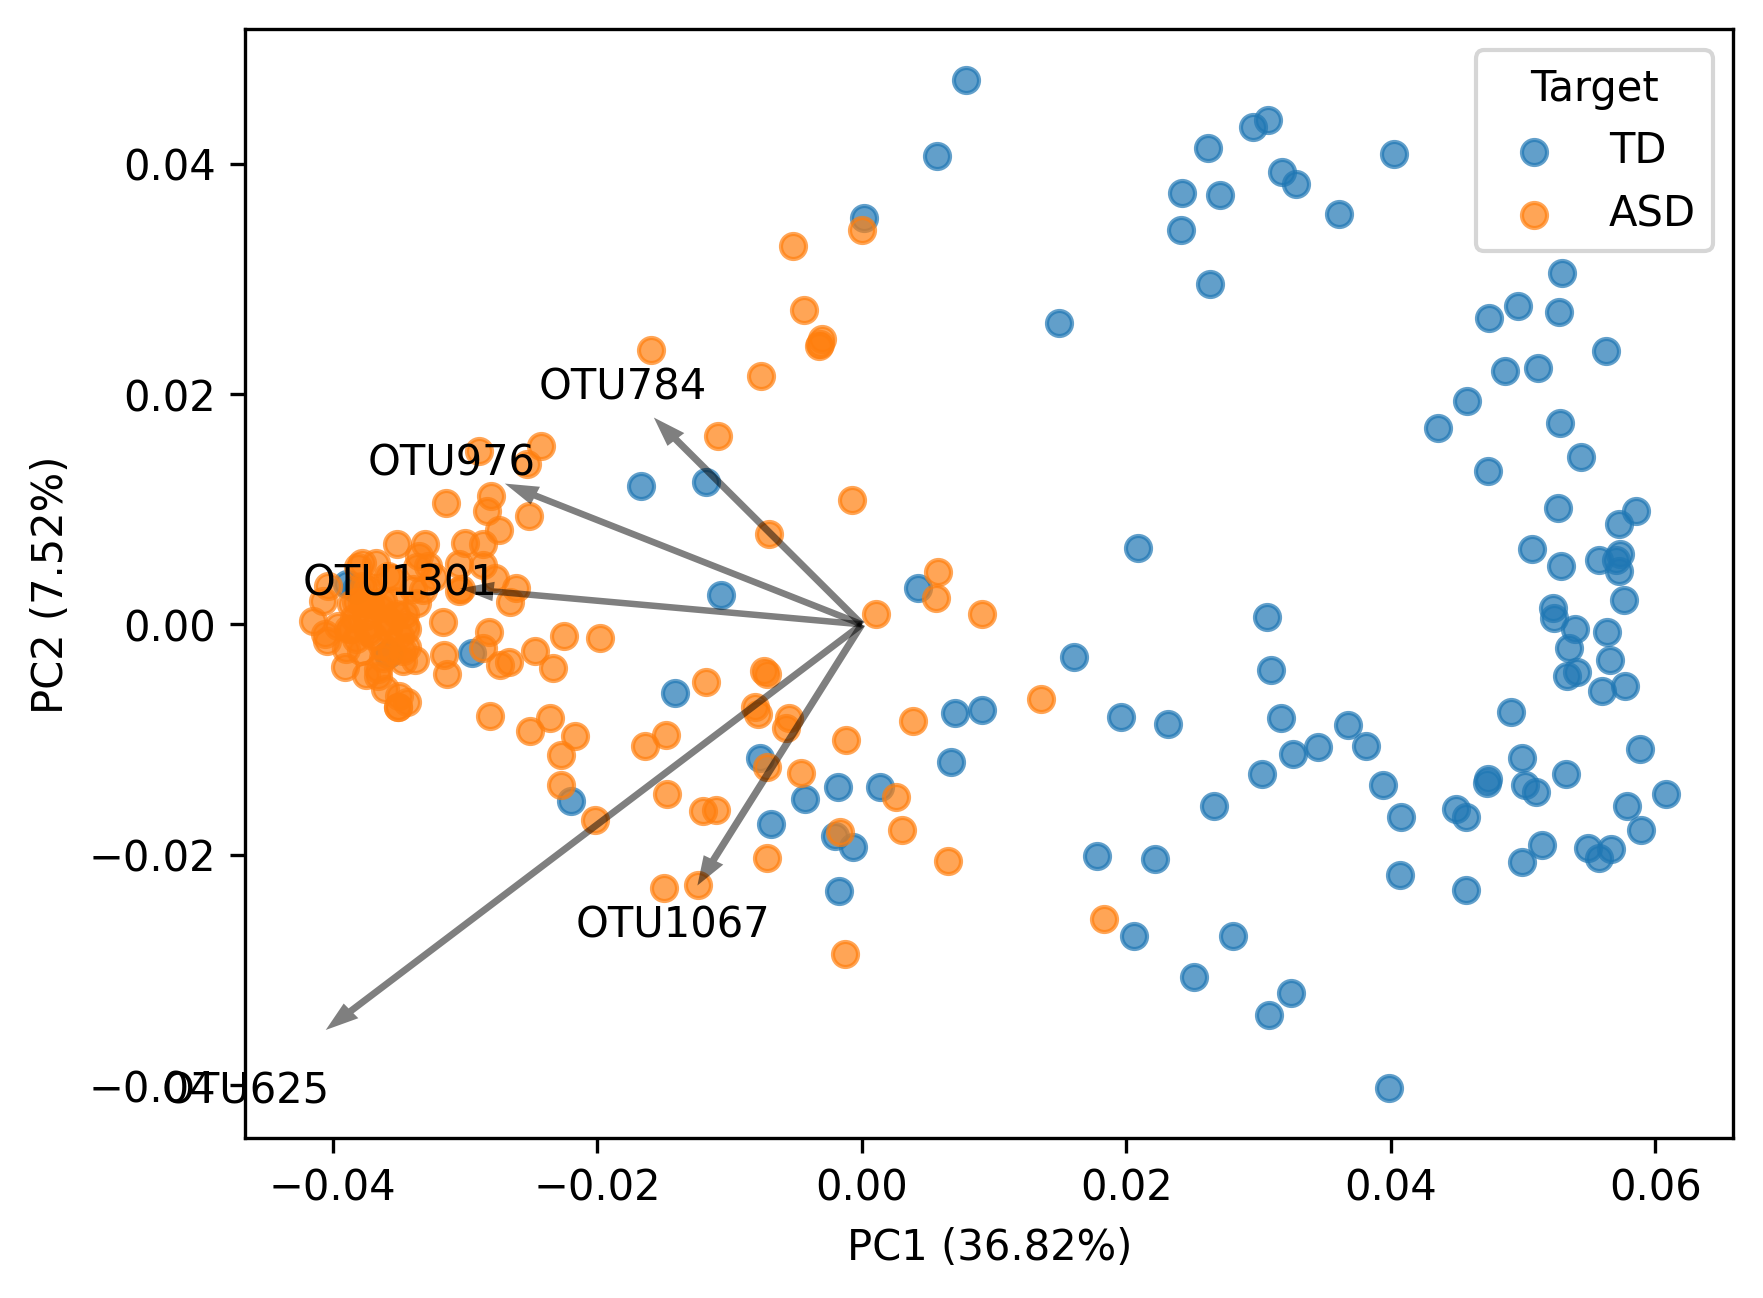

In [28]:
plt.figure(dpi=300)

for i,name in enumerate(['TD','ASD']):
    plt.scatter(*zip(*scores_shap[y == i]), label=name , alpha=0.7)
plt.legend(title='Target')

width = -0.005 * np.min([np.subtract(*plt.xlim()), np.subtract(*plt.ylim())])
for i, arrow in zip(tops, arrows):
    plt.arrow(0, 0, *arrow, color='k', alpha=0.5, width=width, ec='none',
              length_includes_head=True)
    plt.text(*(arrow * 1.15), features[i], ha='center', va='center')

for i, axis in enumerate('xy'):
    getattr(plt, f'{axis}ticks')#([])
    getattr(plt, f'{axis}label')(f'PC{i + 1} ({pvars_shap[i]:.2f}%)')
    
plt.show()

In [33]:
pca_shap = PCA(n_components=2)
#pca.fit(np.array(average_shap_values))

pca_features_shap = pca_shap.fit_transform(np.array(average_shap_values))


print(pca_shap.explained_variance_ratio_)
print(pca_shap.explained_variance_)
pca_features_shap.shape

[0.36815584 0.07522376]
[0.00118963 0.00024307]


(254, 2)

In [34]:
shap_pca=pd.DataFrame(data=pca_features_shap,index=X.index,columns=['PC1','PC2'])
shap_pca['Probability']=average_prob.astype(float)
shap_pca['Target']=y
shap_pca['Target']=shap_pca['Target'].replace({0: 'TD', 1: 'ASD'})

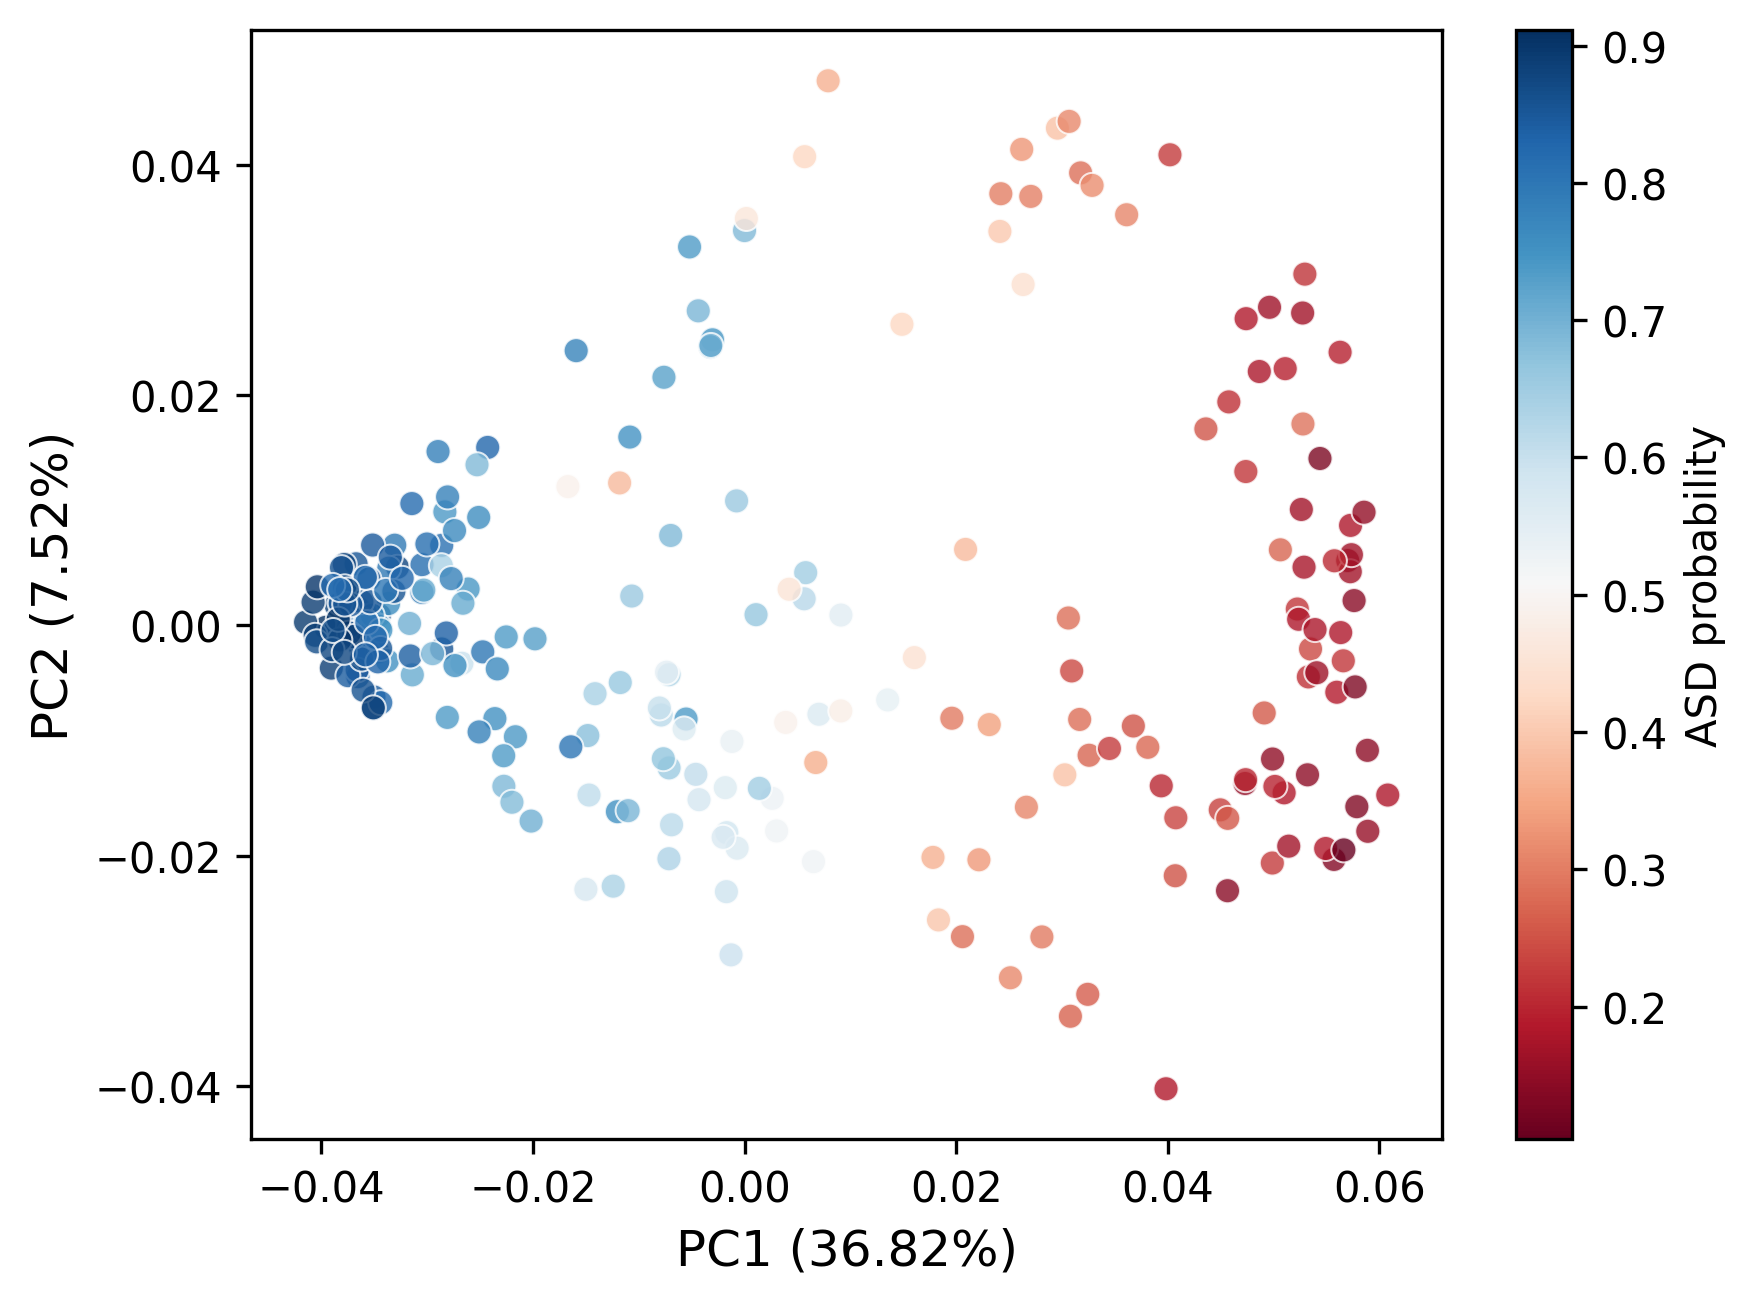

In [35]:
plt.figure(dpi=300)
chart=sns.scatterplot(data=shap_pca, x="PC1", y="PC2", hue="Probability",  palette='RdBu',alpha=0.8)
chart.set_xlabel("PC1 ({:.2%})".format(pca_shap.explained_variance_ratio_[0]), fontdict={'size': 12})
chart.set_ylabel("PC2 ({:.2%})".format(pca_shap.explained_variance_ratio_[1]), fontdict={'size': 12})

norm = plt.Normalize(shap_pca['Probability'].min(), shap_pca['Probability'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

#  add a colorbar
chart.legend_.remove()
cbar=chart.figure.colorbar(sm, ax=plt.gca())
cbar.set_label('ASD probability')

plt.show()

In [54]:
shap_pca.to_csv('prob_xgb.csv')

# k means on PCA SHAP

In [36]:
#clustering of only ASD subjects
X_k=shap_pca.loc[shap_pca['Target']=='ASD'].iloc[:,:2]

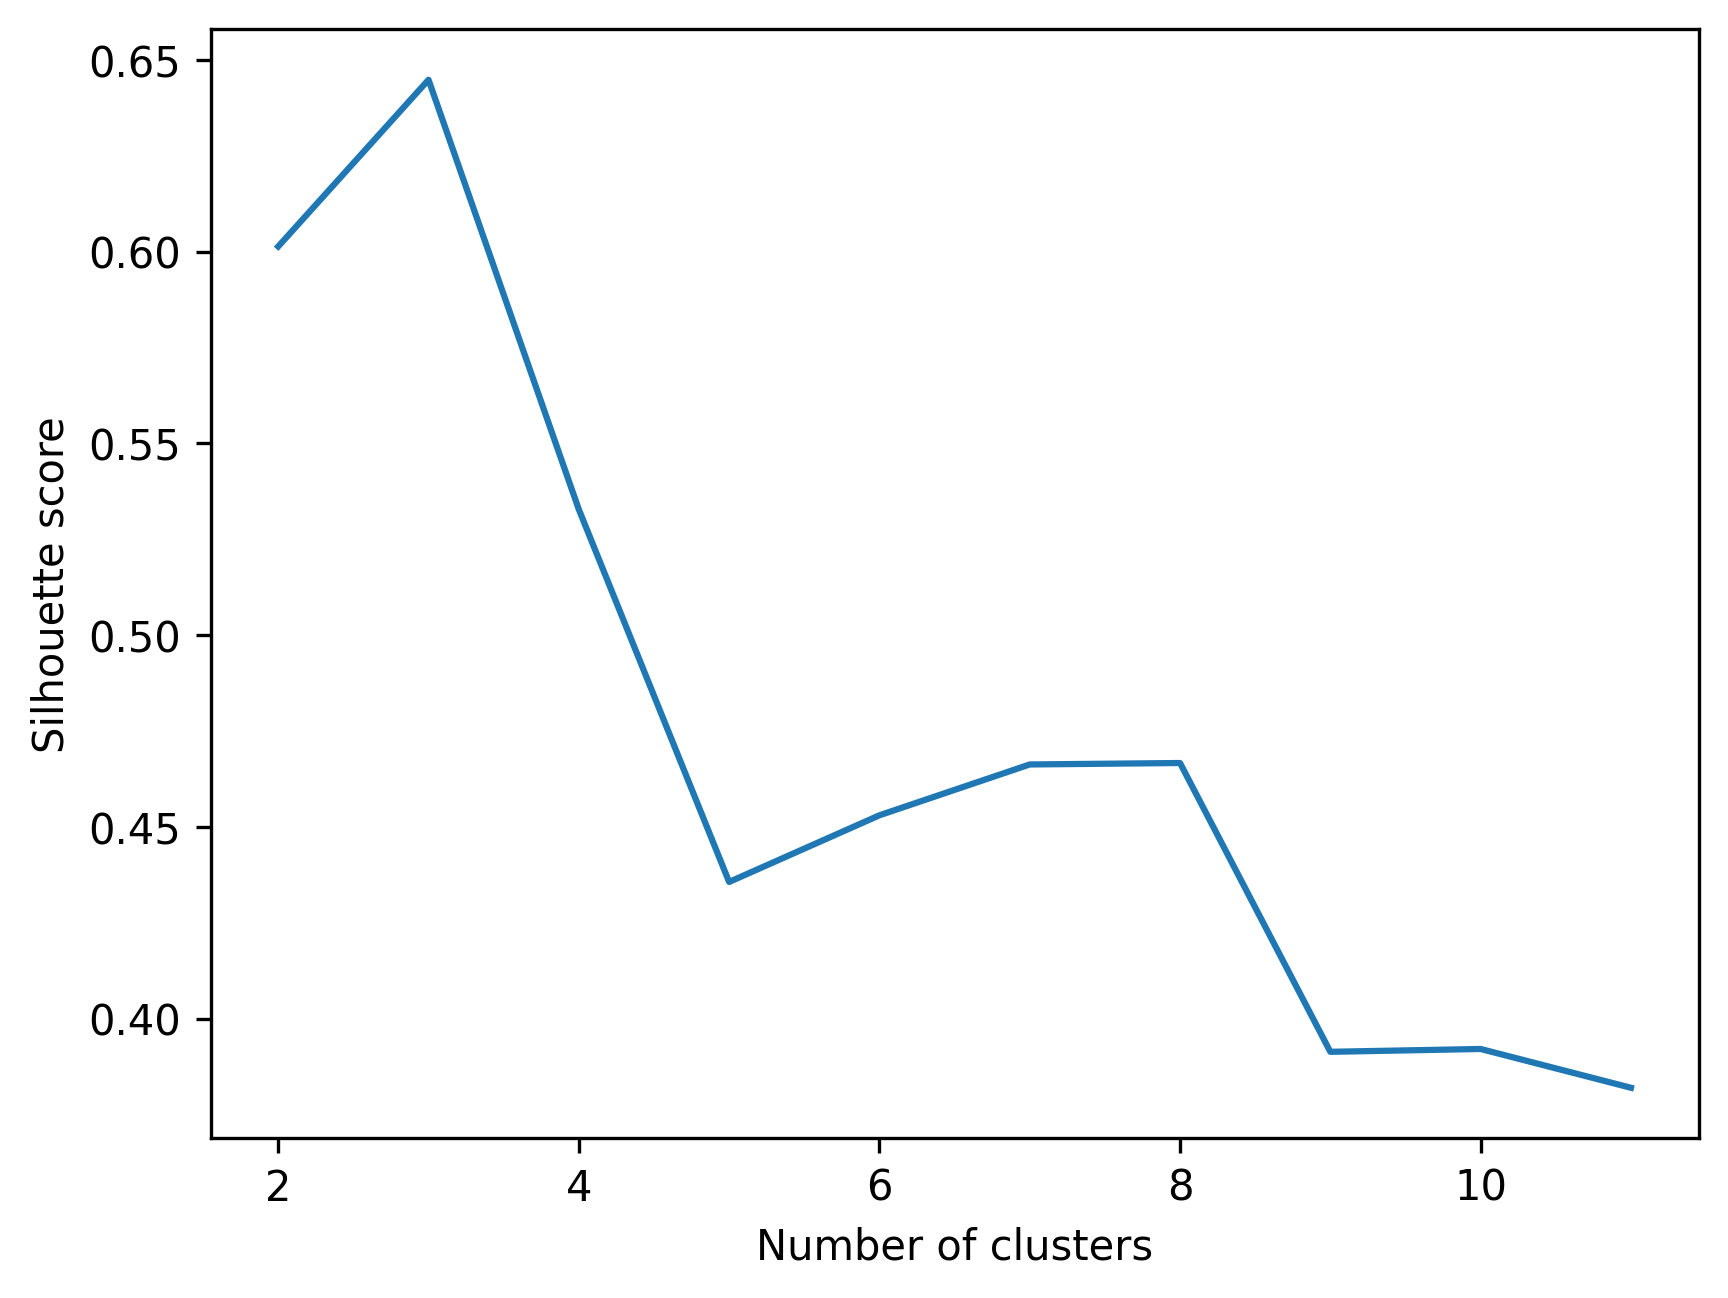

In [39]:
#Silhouette Score
plt.figure(dpi=300)
silhouettes = []
kmin = 2
kmax = 11

for k in range(kmin, kmax+1):
    # We fit the KMeans algo with k clusters
    km=KMeans(n_clusters=k,
             init='k-means++',
             n_init=10,
             max_iter=300,
             random_state=0)
    km.fit(X_k)

    labels = km.labels_
    # We calculate the silhouette score and append it to the silhouette list
    silhouettes.append(silhouette_score(X_k, labels, metric = 'euclidean'))
plt.plot(range(kmin,kmax+1),silhouettes)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

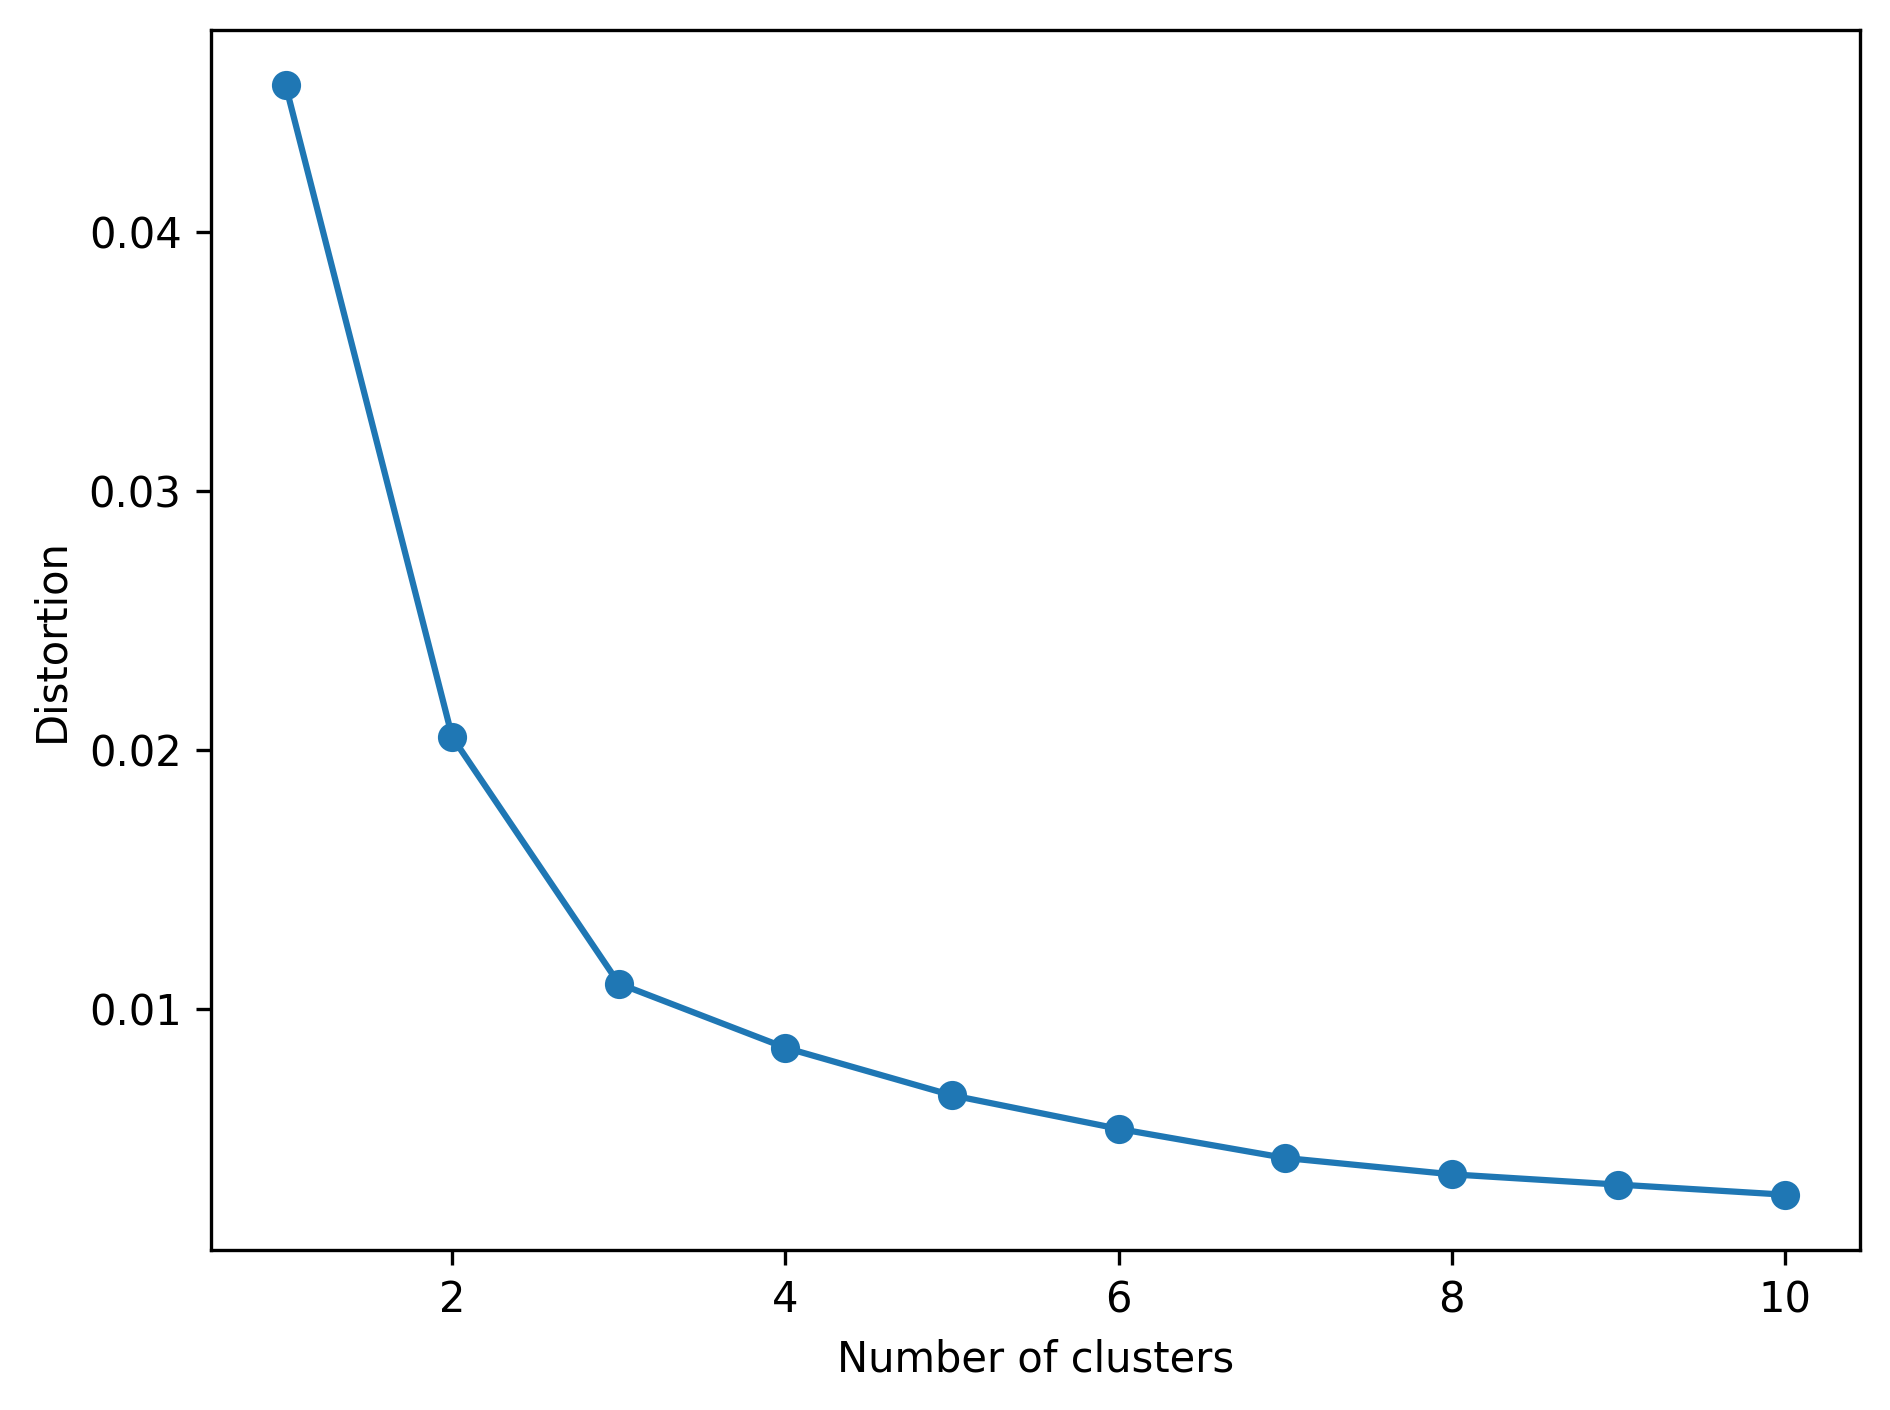

In [40]:
#Elbow Method

distortions=[]

for i in range(1,11):
    km=KMeans(n_clusters=i,
             init='k-means++',
             n_init=10,
             max_iter=300,
             random_state=0)
    km.fit(X_k)
    distortions.append(km.inertia_)
plt.figure(dpi=300)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [41]:
km=KMeans(n_clusters=3,
         init='k-means++',
         n_init=10,
         max_iter=300,
          tol=1e-04,
         random_state=0)
y_km=km.fit_predict(X_k)

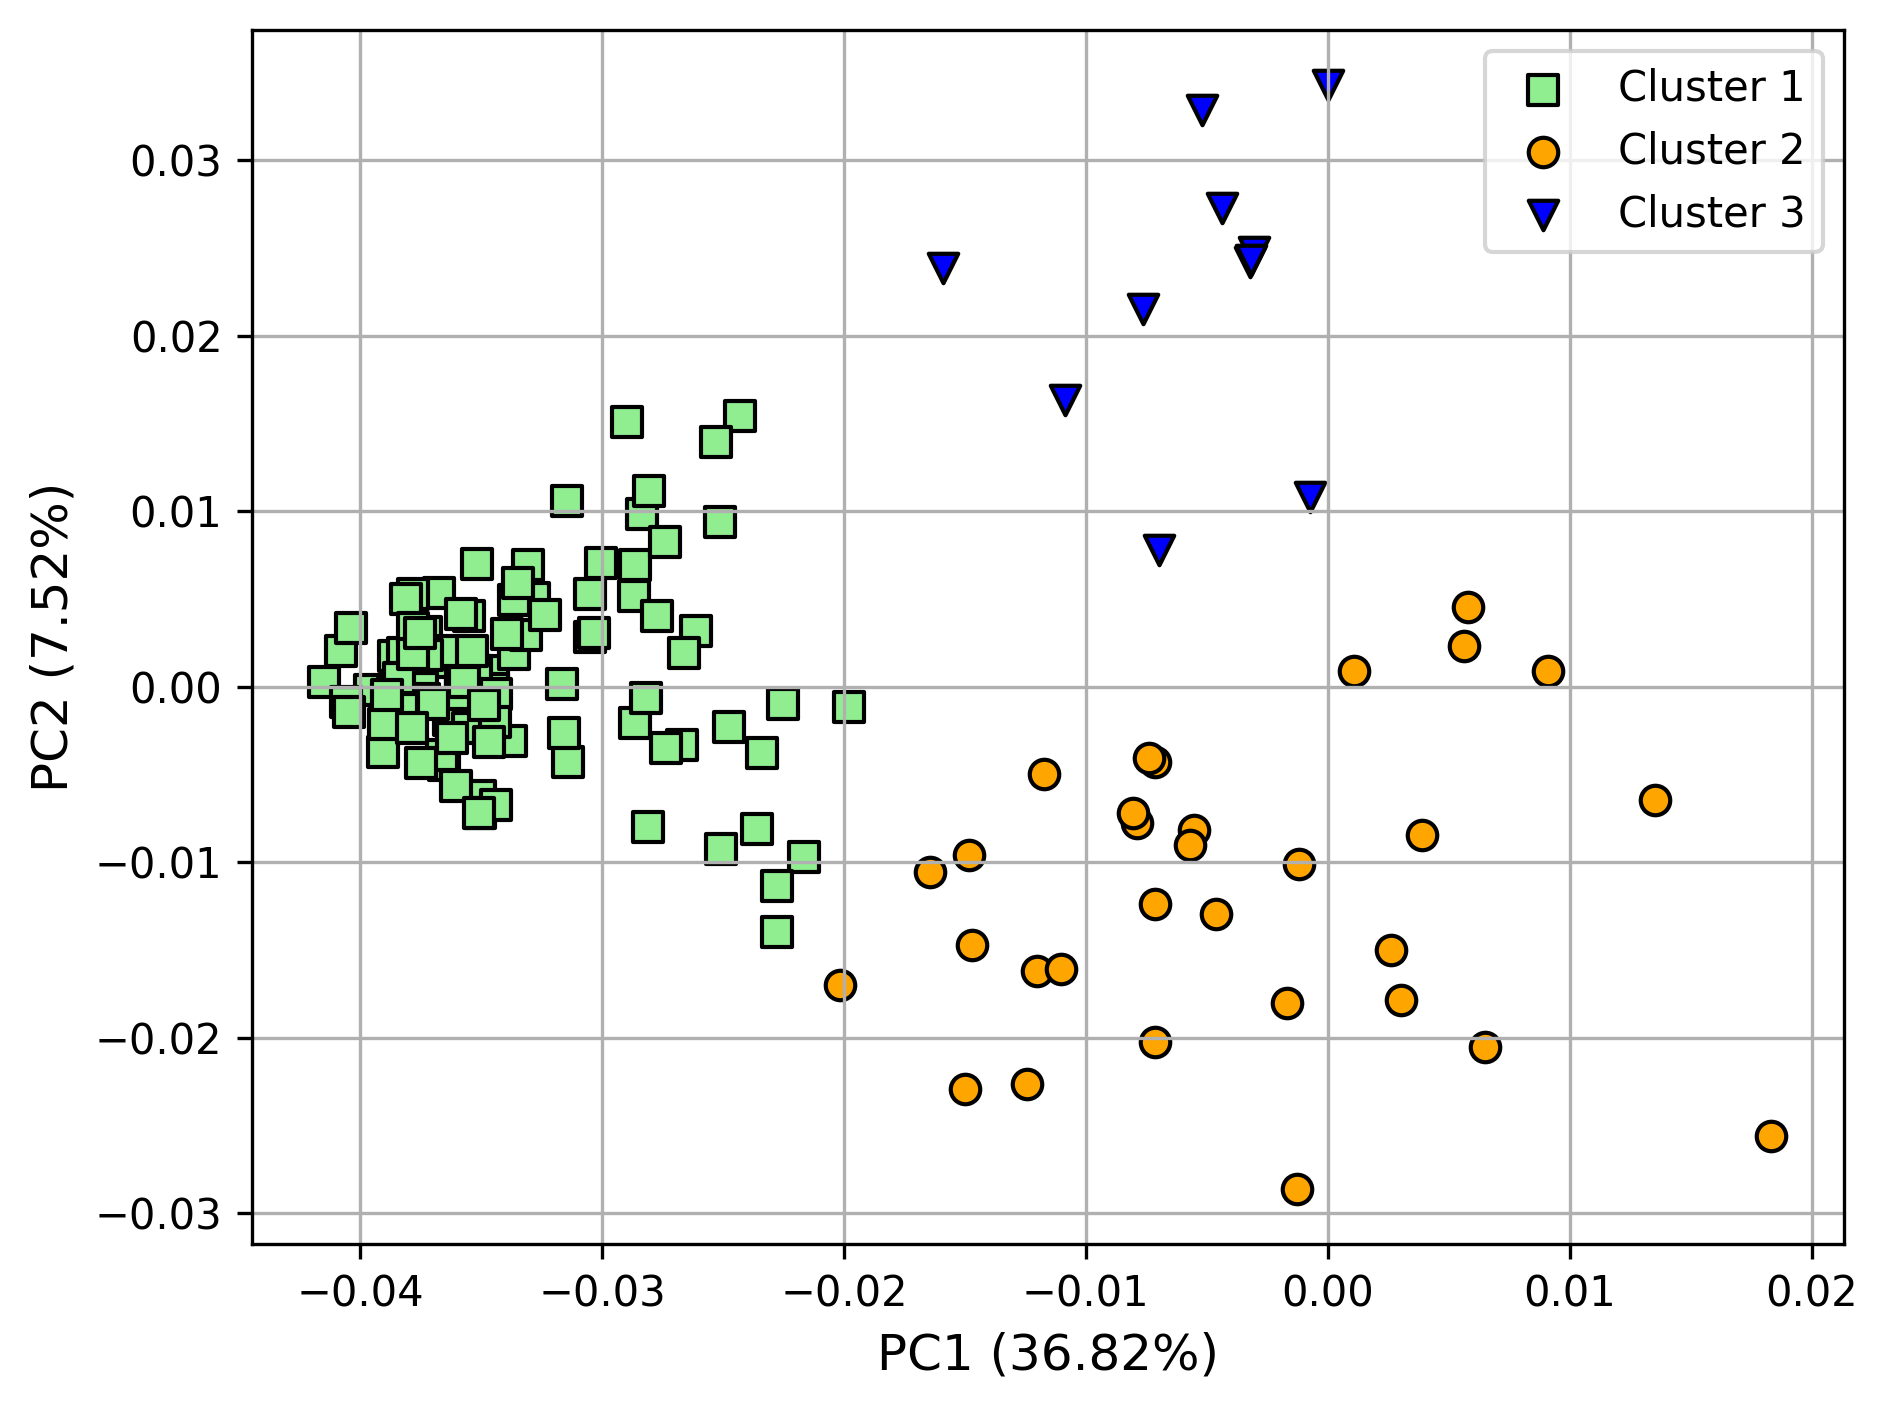

In [42]:
plt.figure(dpi=300)
plt.scatter(X_k[y_km==0]['PC1'],
           X_k[y_km==0]['PC2'],
           s=50, c='lightgreen',
           edgecolor='black',
           marker='s',
           label='Cluster 1')
plt.scatter(X_k[y_km==1]['PC1'],
           X_k[y_km==1]['PC2'],
           s=50, c='orange',
           edgecolor='black',
           marker='o',
           label='Cluster 2')
plt.scatter(X_k[y_km==2]['PC1'],
           X_k[y_km==2]['PC2'],
           s=50, c='blue',
           edgecolor='black',
           marker='v',
           label='Cluster 3')


plt.xlabel("PC1 ({:.2%})".format(pca_shap.explained_variance_ratio_[0]), fontdict={'size': 12})
plt.ylabel("PC2 ({:.2%})".format(pca_shap.explained_variance_ratio_[1]), fontdict={'size': 12})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [43]:
X_kmeans=shap_pca.loc[shap_pca['Target']=='ASD'].iloc[:,:3]
X_kmeans['Clusters']=y_km
X_kmeans['Clusters']=X_kmeans['Clusters'].replace({0: 1, 1: 2,2:3})

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Predicted ASD Probability')]

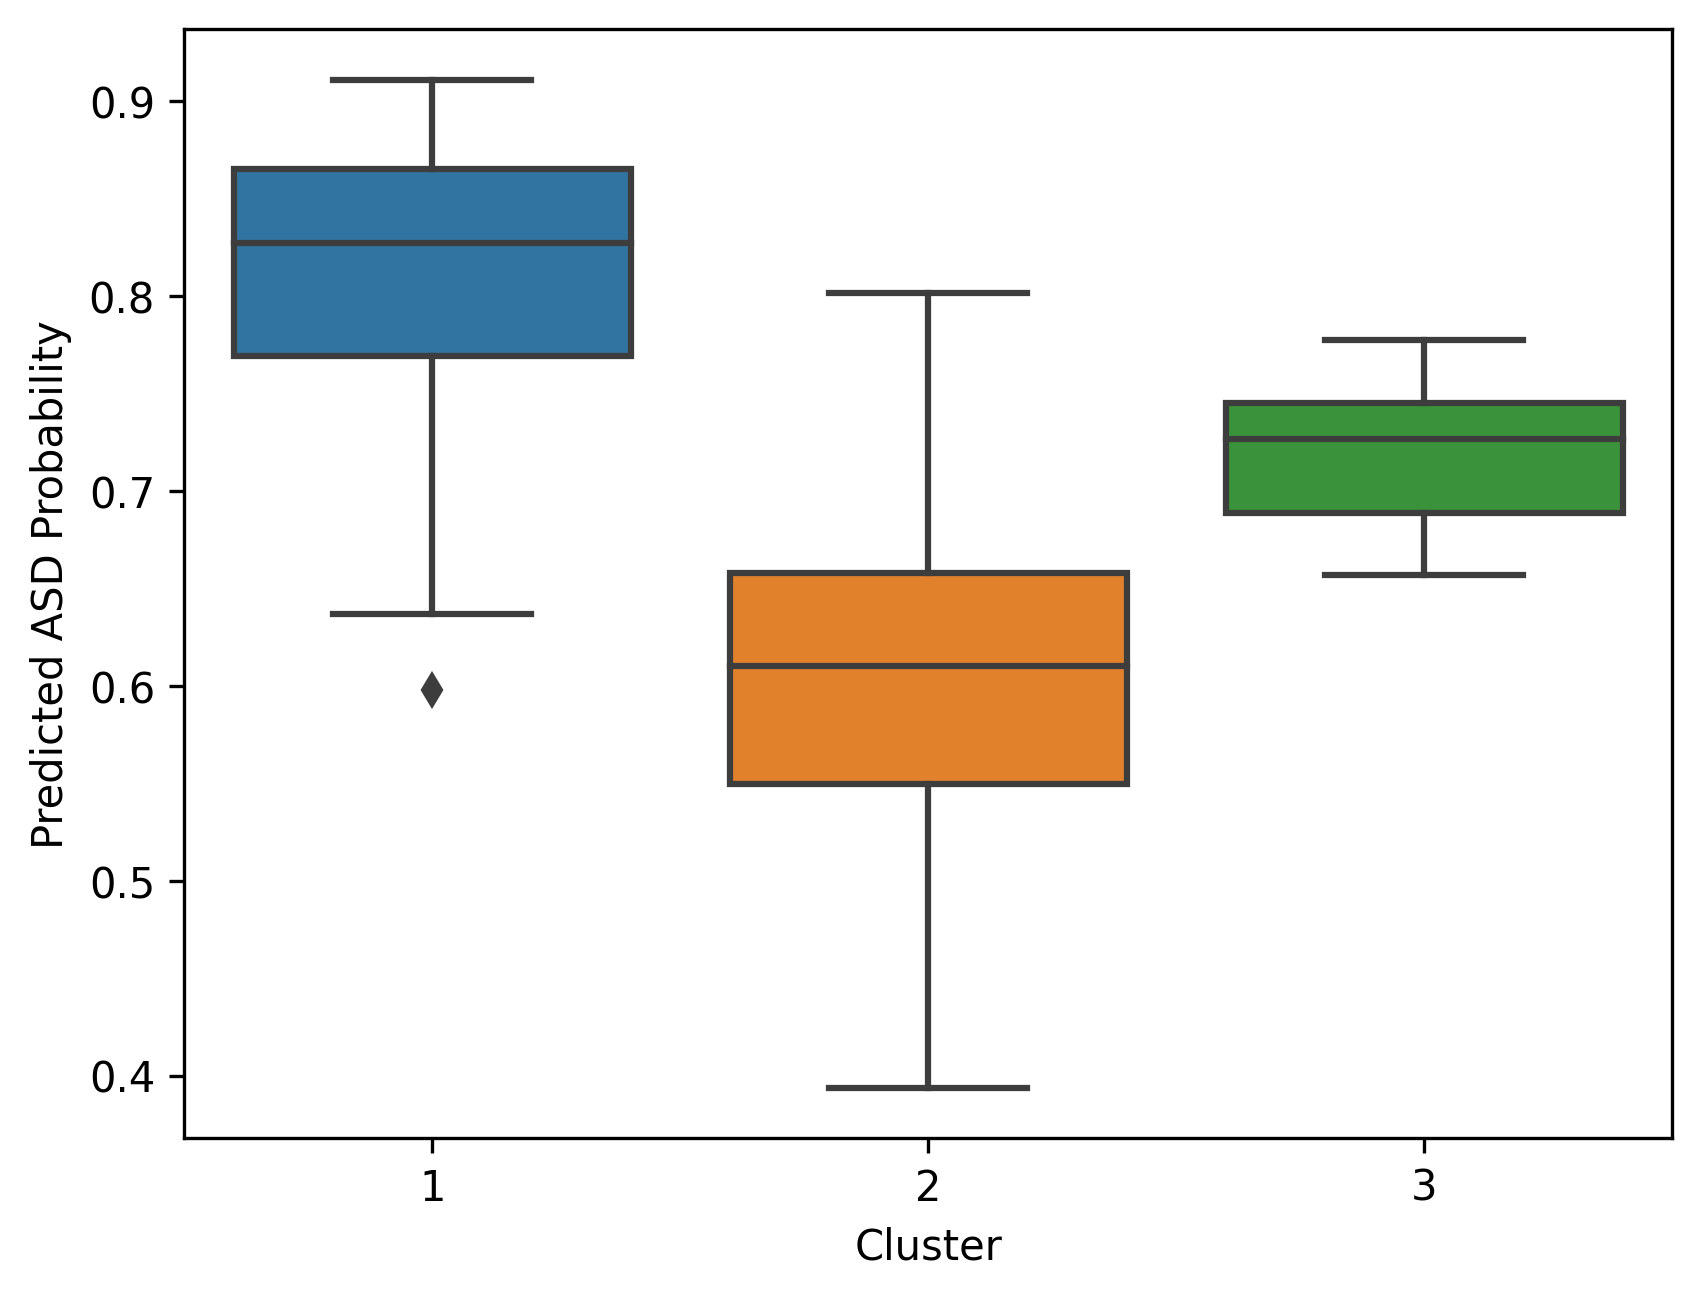

In [44]:
plt.figure(dpi=300)
sns.boxplot(data=X_kmeans, x="Clusters", y="Probability").set(
    xlabel='Cluster', 
    ylabel='Predicted ASD Probability'
)


In [53]:
X_kmeans.loc[X_kmeans['Clusters']==1].index.to_list()

['A102',
 'A105',
 'A109',
 'A11',
 'A110',
 'A113',
 'A114',
 'A115',
 'A116',
 'A117',
 'A118',
 'A119',
 'A120',
 'A122',
 'A124',
 'A125',
 'A126',
 'A128',
 'A129',
 'A130',
 'A131',
 'A132',
 'A133',
 'A135',
 'A136',
 'A137',
 'A139',
 'A140',
 'A141',
 'A143',
 'A144',
 'A145',
 'A146',
 'A147',
 'A148',
 'A149',
 'A150',
 'A151',
 'A152',
 'A153',
 'A154',
 'A156',
 'A157',
 'A159',
 'A160',
 'A161',
 'A162',
 'A163',
 'A164',
 'A166',
 'A167',
 'A168',
 'A169',
 'A18',
 'A23',
 'A25',
 'A26',
 'A27',
 'A28',
 'A31',
 'A32',
 'A33',
 'A34',
 'A35',
 'A43',
 'A45',
 'A46',
 'A47',
 'A49',
 'A50',
 'A51',
 'A52',
 'A53',
 'A54',
 'A55',
 'A57',
 'A58',
 'A59',
 'A60',
 'A62',
 'A63',
 'A66',
 'A67',
 'A68',
 'A69',
 'A71',
 'A72',
 'A73',
 'A75',
 'A76',
 'A77',
 'A78',
 'A80',
 'A82',
 'A83',
 'A87',
 'A88',
 'A89',
 'A90',
 'A91',
 'A99']

In [48]:
X_kmeans.loc[X_kmeans['Clusters']==2].index

Index(['A1', 'A10', 'A100', 'A101', 'A104', 'A106', 'A108', 'A111', 'A123',
       'A142', 'A155', 'A158', 'A165', 'A2', 'A29', 'A3', 'A40', 'A5', 'A6',
       'A61', 'A65', 'A7', 'A70', 'A8', 'A84', 'A86', 'A9', 'A92', 'A93',
       'A95', 'A97'],
      dtype='object')

In [49]:
X_kmeans.loc[X_kmeans['Clusters']==3].index

Index(['A112', 'A12', 'A121', 'A14', 'A16', 'A17', 'A19', 'A20', 'A21', 'A22',
       'A85'],
      dtype='object')

# local explanation

In [45]:
plt.figure(dpi=300)
shap.plots.bar(explainer(X_test.loc['B114']), max_display=20)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

<Figure size 1920x1440 with 0 Axes>